In [11]:
import torch

from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

import datamanip.plots
import importlib
from datamanip.datasetmanip.three_five_dataset import ThreeFiveDataset

importlib.reload(datamanip.plots)
importlib.reload(datamanip.datasetmanip.three_five_dataset)



<module 'datamanip.datasetmanip.three_five_dataset' from 'C:\\Users\\pavel\\PycharmProjects\\ADES-reliability\\src\\datamanip\\datasetmanip\\three_five_dataset.py'>

In [12]:

from filepath import *
from datamanip.plots import generate_matrix, visualize_samples_outside_of_radii
from models.GAT import GAT#, GCN, SimpleMPNN
from train_eval.train import train
from train_eval.evaluate import evaluate_multiclass



In [13]:
# Number of epochs to train the model
NUM_EPOCHS = 100

# Dropout rate for the model to prevent overfitting
DROPOUT_RATE = 0.3

# Learning rate for the optimizer
LEARNING_RATE = 0.0005

# Threshold for classifying reliability
THRESHOLD = 0.97

# Number of features for each node in the graph
NODE_FEATURES = 12

# Number of epochs to wait for improvement before early stopping
PATIENCE = 20

# Flag to indicate whether to use only one timestamp
ONE_TIMESTAMP = False

NUM_BINS = 8

In [14]:
train_set = ThreeFiveDataset(root=dataset_path, match='ensemble', test_train_val="train")
test_set = ThreeFiveDataset(root=dataset_path, match='ensemble', test_train_val="test")
val_set = ThreeFiveDataset(root=dataset_path, match='ensemble', test_train_val="val")
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(input_dim=NODE_FEATURES, hidden_dim=64, output_dim=NUM_BINS, dropout_rate=DROPOUT_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [16]:
train_config = {
    "num_epochs": NUM_EPOCHS,
    "patience": PATIENCE,
    "device": device,
    "criterion": criterion,
    "optimizer": optimizer,
}

In [ ]:
train(model, train_loader, val_loader, train_config, model_checkpoints_path + "best_model_GAT_MCC.pth")

In [9]:
# Load the best model after training
model.load_state_dict(torch.load(model_checkpoints_path + "best_model_GAT_MCC.pth", weights_only=True))

<All keys matched successfully>

In [10]:
true_values, predicted_values, accuracy, rmse, outside_1, outside_2 = evaluate_multiclass(device, model, test_loader, model_checkpoints_path + "best_model_GAT_MCC.pth")

GAT(
  (conv1): GATConv(10, 64, heads=1)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(64, 32, heads=1)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=8, bias=True)
)
[np.int64(4), np.int64(3), np.int64(2), np.int64(3), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(1)]
[np.int64(4), np.int64(3), np.int64(2), np.int64(3), np.int64(3), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(1)]
Accuracy: 0.7183


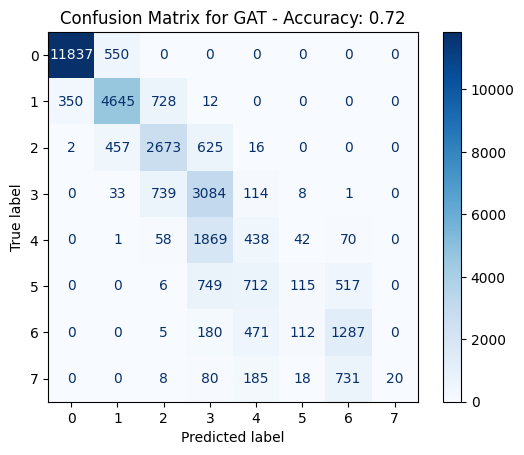

In [11]:
generate_matrix(true_values, predicted_values, accuracy, "GAT")
visualize_samples_outside_of_radii(accuracy, outside_1, outside_2)